In [1]:
%pip install pycaret
%pip install fsspec openpyxl


Note: you may need to restart the kernel to use updated packages.



In [2]:
from pycaret.classification import *
from pycaret.regression import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
pm_data = pd.read_csv("clean_data\\cleaned_data.csv")
pm_data = pm_data.drop(["Unnamed: 0"],axis=1)
pm_data["timestamp"] = pd.to_datetime(pm_data["timestamp"])
print(pm_data)

               timestamp   humidity     pm_2_5  temperature
0    2021-08-16 07:00:00  97.712066   5.979462    24.220945
1    2021-08-17 07:00:00  95.922874   9.142292    24.807743
2    2021-08-18 07:00:00  87.291672   7.901869    26.346601
3    2021-08-19 07:00:00  86.124131  10.989553    27.062054
4    2021-08-20 07:00:00  89.532874   8.201077    26.208938
...                  ...        ...        ...          ...
1995 2021-10-17 06:00:00  91.460667   0.017094    22.848063
1996 2021-10-17 07:00:00  89.727773   0.008621    22.995754
1997 2021-10-17 08:00:00  86.384701   0.000000    23.557021
1998 2021-10-17 09:00:00  85.498444   0.025641    23.630604
1999 2021-10-17 10:00:00  77.589990   0.000000    25.050899

[2000 rows x 4 columns]


In [4]:
s = setup(pm_data, target = 'pm_2_5', session_id = 123,date_features=["timestamp"],normalize=True)

,Description,Value
0,Session id,123
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(2000, 4)"
4,Transformed data shape,"(2000, 6)"
5,Transformed train set shape,"(1400, 6)"
6,Transformed test set shape,"(600, 6)"
7,Numeric features,2
8,Date features,1
9,Preprocess,True


In [5]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,20.4627,21429.8678,127.8575,0.9041,0.7986,1.8374,0.0330
rf,Random Forest Regressor,18.0329,29796.6173,136.8624,0.8643,0.6097,1.6691,0.0480
lightgbm,Light Gradient Boosting Machine,35.8239,35791.3015,159.4172,0.8260,1.2742,5.2662,0.0660
ada,AdaBoost Regressor,41.1019,48881.4032,211.1542,0.8210,1.0965,5.7758,0.0120
gbr,Gradient Boosting Regressor,35.7269,38241.9933,169.9641,0.8128,1.2891,8.5674,0.0230
dt,Decision Tree Regressor,15.9361,38596.9190,128.9697,0.8050,0.6774,1.6292,0.0070
knn,K Neighbors Regressor,52.7906,72374.2307,260.5418,0.7537,1.0480,9.4041,0.0140
br,Bayesian Ridge,193.3358,231893.0987,477.5750,0.1837,2.4724,37.7198,0.0080
llar,Lasso Least Angle Regression,193.4383,231884.1173,477.5672,0.1836,2.4745,37.6490,0.0090
lasso,Lasso Regression,193.4354,231884.2603,477.5671,0.1836,2.4745,37.6525,0.2160


In [6]:
best_model = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,32.9097,66602.7467,258.0751,0.5712,0.7285,1.0106
1,28.6581,33877.7597,184.0591,0.9251,0.6504,1.0524
2,13.8153,3411.1935,58.4054,0.9910,0.7869,1.4677
3,24.5915,24680.6571,157.1008,0.9173,0.5623,1.5266
4,6.9764,301.1888,17.3548,0.9981,0.9119,1.0409
5,15.8908,3200.8351,56.5759,0.9929,0.8514,3.9883
6,11.7851,4502.2806,67.0990,0.9853,0.4796,0.7092
7,24.0523,32518.5896,180.3291,0.7909,0.9394,2.5366
8,24.1436,26452.9773,162.6437,0.9305,1.0233,1.9464


In [7]:
best_model_tune = tune_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,46.1541,59407.5465,243.7366,0.6175,1.0906,2.1799
1,48.1131,40950.6720,202.3627,0.9095,1.1385,3.0496
2,33.7691,15522.0941,124.5877,0.9591,1.1232,5.1171
3,29.5976,18416.9443,135.7090,0.9383,0.8138,3.8868
4,36.5540,18650.9553,136.5685,0.8800,1.4888,5.2304
5,52.2972,33363.4561,182.6567,0.9262,1.3326,10.6065
6,32.6497,21345.8887,146.1023,0.9303,0.8847,6.9123
7,53.0549,81744.3637,285.9097,0.4743,1.5023,11.4958
8,61.3741,57529.2917,239.8526,0.8488,1.6712,8.2687


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [8]:
ensem_best_model = ensemble_model(best_model_tune, n_estimators = 50)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,32.8201,64567.8287,254.1020,0.5843,0.8066,1.0931
1,31.2094,32646.9128,180.6846,0.9278,0.8706,1.3481
2,22.7916,8026.0377,89.5882,0.9789,0.9493,2.1111
3,28.6326,32709.8811,180.8587,0.8905,0.6724,2.1168
4,13.7372,2674.9978,51.7204,0.9828,1.1380,1.6147
5,27.3238,9947.4275,99.7368,0.9780,1.0992,6.1983
6,18.6391,11984.2071,109.4724,0.9609,0.6168,1.3611
7,30.6751,38168.9372,195.3687,0.7545,1.2335,4.1573
8,32.8782,36034.8502,189.8285,0.9053,1.2873,2.5416


In [14]:
now = pd.Timestamp.now()
startdate = now.date()
enddate = startdate + pd.DateOffset(days=7)
next_week = pd.date_range(start=startdate, end=enddate, freq='D')

In [17]:
next_data = pd.DataFrame({'timestamp': next_week})
next_data['pm_2_5'] = pm_data['pm_2_5'].mean().round(2)
next_data['humidity'] = pm_data['humidity'].mean().round(2)
next_data['temperature'] = pm_data['temperature'].mean().round(2)

In [18]:
predict = predict_model(ensem_best_model, data=next_data)
data_plot = pd.DataFrame(predict, columns=['timestamp', 'prediction_label'])
data_plot["prediction_label"] = data_plot["prediction_label"].round(2)
data_plot

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,69.7264,4862.4685,69.7314,0.0000,1.2898,0.7320


,timestamp,prediction_label
0,2025-03-11,25.92
1,2025-03-12,25.74
2,2025-03-13,25.49
3,2025-03-14,25.15
4,2025-03-15,25.47
5,2025-03-16,27.08
6,2025-03-17,25.50
7,2025-03-18,23.84


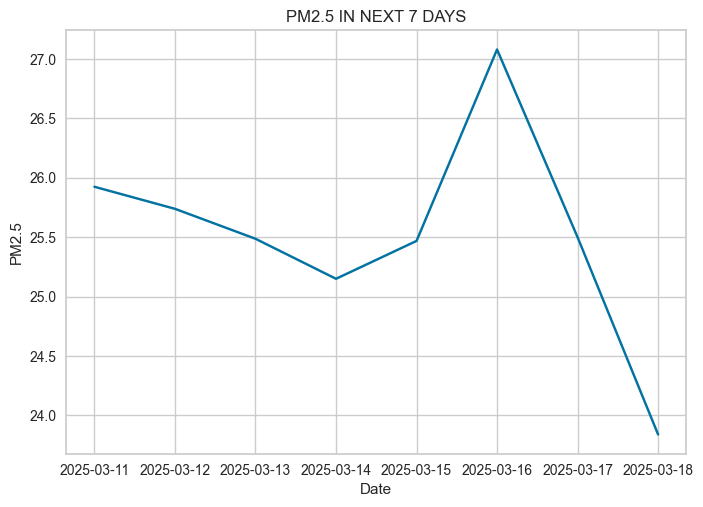

In [19]:
plt.plot(next_week, predict['prediction_label'])
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.title('PM2.5 IN NEXT 7 DAYS')
plt.grid(True)
plt.show()

In [20]:
save_model(ensem_best_model,'pm_2_5')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(include=['timestamp'],
                                     transformer=ExtractDateTimeFeatures())),
                 ('numerical_imputer',
                  TransformerWrapper(include=['humidity', 'temperature'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('normalize', TransformerWrapper(transformer=StandardScaler())),
                 ('trained_model',
                  BaggingRegressor(estimator=ExtraTreesRegressor(n_jobs=-1,
                                                                 random_state=123),
                                   n_estimators=50, random_state=123))]),
 'pm_2_5.pkl')

In [21]:
predict_pm25 = pm_data
cleaned_file_path = ('C:\\Users\\asus\\OneDrive\\Desktop\\เอกสาร\\241-152\\termpro-predictPM25\\pm_2_5.pkl')
predict_pm25.to_csv(cleaned_file_path, index=False)